# DAA

In [1]:
!pip3 install finance-datareader==0.9.42
!pip3 install pandas-datareader==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 8.0 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
import FinanceDataReader as fdr
import pandas_datareader.data as web
from pandas_datareader import data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
def getCloseData(ticker, start, end=None):
    return fdr.DataReader(ticker, start, end)['Close']

def getCloseDataPandas(ticker, start, end):
    return data.get_data_yahoo(ticker, start, end)['Close']


def getDayReturn(closeDataSet):
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)


def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]


def getPortfolioResult(closeDataSet, weight=None):

    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)

    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)

    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn


def getEvaluation(cumulativeReturn):

    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()

    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd


def getRebalancingDate(closeDataSet, period="month"):

    data = closeDataSet.copy()
    data = pd.DataFrame(data) # 시리즈형 데이터가 들어오더라도 리밸런싱 날짜를 계산하기
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    # 월말 리밸런싱
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        # rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last")
        check = int(rebalancingDate.iloc[len(rebalancingDate)-1].to_list()[len(rebalancingDate.columns)-1])
        rebalancingDate= rebalancingDate[rebalancingDate['month']==check].index
    return rebalancingDate


def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):

    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)]
                                * len(rebalancingDate),index=rebalancingDate,columns=closeDataSet.columns)
        
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜

    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성
    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[end] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
        start = end # start 갱신
        if(netCumReturn.iloc[-1].sum() ==0):
            totalAsset =1
        else:
            totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn

def getDay(str0):
    SY = int(str0[:4])
    SM = int(str0[5:7])
    SD = int(str0[8:10])
    return SY,SM,SD 

In [4]:
def avgMomentumScoretable(data, n=12, name="Close"):
  result = pd.DataFrame(data)

  if len(result.columns) ==1 :  
    result.columns = [name+"_m"]
    for i in range(len(data)-1,-1,-1):
      tmp =0
      if i>(n-1):
        for j in range(i-1,i-n-1, -1):
          if data[i]>data[j] : tmp = tmp+1
      result[name+"_m"][i] = tmp
  else : 
    name_list = result.columns
    for i in range(0, len(name_list)):
      result = pd.concat(   [result,avgMomentumScoretable(data[name_list[i]],n, name_list[i])/n] , axis=1 )
      result = result.drop([name_list[i]], axis=1)
    result.columns = name_list

  return  result[n:]

In [5]:
def weightScore(data):
  weight = data.divide(data.sum(axis=1), axis=0).fillna(0)
  # weight['cash'] = np.where(weight.sum(axis=1) == 0,1,0)
  return weight

In [62]:
start = "2003"
end = "2022-10-31"

In [63]:
#공격형 자산
SPY = getCloseDataPandas("SPY",start, end) #1
QQQ = getCloseDataPandas("QQQ",start, end) #2
IWM = getCloseDataPandas("IWM",start, end) #3
VGK = getCloseDataPandas("VGK",start, end) #4
EWJ = getCloseDataPandas("EWJ",start, end) #5
EEM = getCloseDataPandas("EEM",start, end) #6
VNQ = getCloseDataPandas("VNQ",start, end) #7
GLD = getCloseDataPandas("GLD",start, end) #8
DBC = getCloseDataPandas("DBC",start, end) #9
HYG = getCloseDataPandas("HYG",start, end) #10
TLT = getCloseDataPandas("TLT",start, end) #12
LQD = getCloseDataPandas("LQD",start, end) #11

#안전자산
# LQD = getCloseDataPandas("LQD",start, end) #5
IEF = getCloseDataPandas("IEF",start, end)  # 6
SHY = getCloseDataPandas("SHY",start, end) #74

VWO = getCloseDataPandas("VWO", start,end)
BND = getCloseDataPandas("BND", start, end)


closeDataSet = pd.concat([SPY,QQQ,IWM,VGK,EWJ,EEM,VNQ, GLD, DBC,HYG,TLT,LQD,IEF,SHY,VWO,BND], axis=1)
closeDataSet.columns = ["SPY","QQQ","IWM","VGK","EWJ","EEM","VNQ", "GLD", "DBC","HYG","TLT","LQD","IEF","SHY",'VWO','BND']
closeDataSet.dropna(inplace=True)
closeDataSet

,SPY,QQQ,IWM,VGK,EWJ,EEM,VNQ,GLD,DBC,HYG,TLT,LQD,IEF,SHY,VWO,BND
Date,,,,,,,,,,,,,,,,
2007-04-11,144.020004,44.209999,80.300003,72.750000,58.599998,40.073334,79.349998,67.080002,25.410000,104.349998,87.370003,106.320000,82.400002,80.120003,40.869999,75.040001
2007-04-12,144.660004,44.560001,80.839996,73.400002,58.520000,40.743332,78.809998,66.989998,25.559999,104.419998,87.389999,106.480003,82.480003,80.110001,41.389999,75.029999
2007-04-13,145.320007,44.650002,81.360001,73.809998,58.040001,40.943333,79.699997,67.839996,25.700001,104.230003,87.120003,106.300003,82.339996,80.070000,41.525002,74.910004
2007-04-16,146.699997,45.060001,82.480003,74.620003,58.880001,41.430000,79.800003,68.400002,25.500000,104.190002,87.599998,106.389999,82.430000,80.059998,42.044998,74.980003
2007-04-17,147.089996,45.160000,82.230003,74.639999,58.520000,41.206669,80.839996,68.000000,25.240000,104.139999,88.089996,106.970001,82.779999,80.190002,41.895000,75.169998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25,384.920013,284.209991,178.169998,49.990002,50.090000,34.209999,81.209999,154.000000,25.090000,73.239998,95.089996,100.760002,94.180000,81.000000,35.610001,70.059998
2022-10-26,382.019989,277.929993,179.050003,50.529999,50.380001,34.770000,81.160004,154.979996,25.559999,73.440002,96.459999,101.220001,94.660004,81.070000,36.090000,70.339996
2022-10-27,379.980011,272.869995,179.089996,50.099998,49.750000,34.500000,81.279999,154.740005,25.600000,73.980003,97.470001,101.690002,95.330002,81.239998,35.830002,70.709999


In [64]:
rebalDate = getRebalancingDate(closeDataSet) #rebalancing_date
priceOnRebalDate = closeDataSet.loc[rebalDate] #rebal_close_data

In [82]:
name_list = ["SPY","QQQ","IWM","VGK","EWJ","EEM","VNQ", "GLD", "DBC","HYG","TLT","LQD","IEF","SHY",'VWO','BND']

weight = priceOnRebalDate.copy()
final_weight = pd.DataFrame( index = priceOnRebalDate.index, columns=priceOnRebalDate.columns)

for i in name_list:
  weight['mthavg_'+i] = ( 12 * ((priceOnRebalDate[i]/priceOnRebalDate[i].shift(1)) -1)) +( 4 * ((priceOnRebalDate[i]/priceOnRebalDate[i].shift(3)) -1))+( 2 * ((priceOnRebalDate[i]/priceOnRebalDate[i].shift(6)) -1))+( 1 * ((priceOnRebalDate[i]/priceOnRebalDate[i].shift(12)) -1))
  
#n개월 수익률 (현재가/n개월 전가격)-1

In [83]:
weight['ff'] =0

In [84]:
weight['ff'] = np.where((weight['mthavg_VWO']<=0) & (weight['mthavg_BND']<=0), 0, weight['ff']) 
weight['ff'] = np.where((weight['mthavg_VWO']>=0) | (weight['mthavg_BND']>=0), 0.5, weight['ff']) 
weight['ff'] = np.where((weight['mthavg_VWO']>=0) & (weight['mthavg_BND']>=0), 1, weight['ff']) 


In [85]:
weight

,SPY,QQQ,IWM,VGK,EWJ,EEM,VNQ,GLD,DBC,HYG,...,mthavg_GLD,mthavg_DBC,mthavg_HYG,mthavg_TLT,mthavg_LQD,mthavg_IEF,mthavg_SHY,mthavg_VWO,mthavg_BND,ff
Date,,,,,,,,,,,,,,,,,,,,,
2007-04-30,148.289993,45.959999,80.739998,75.000000,57.119999,40.279999,79.250000,67.089996,25.570000,105.610001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2007-05-31,153.320007,47.410000,84.269997,76.599998,58.400002,42.320000,78.949997,65.540001,25.510000,105.709999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2007-06-29,150.429993,47.599998,82.900002,76.330002,58.040001,43.876667,70.949997,64.269997,25.700001,101.809998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2007-07-31,145.720001,47.529999,77.099998,74.160004,57.720001,44.189999,65.089996,65.790001,26.190001,97.279999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2007-08-31,147.589996,48.869999,78.739998,74.360001,56.279999,44.650002,69.480003,66.519997,25.690001,101.669998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,377.250000,280.279999,169.360001,52.820000,52.830002,40.099998,91.110001,168.460007,26.639999,73.610001,...,-0.469990,0.136925,-1.782892,-1.349105,-1.343768,-0.645971,-0.210909,-1.484588,-0.785175,0.0
2022-07-29,411.989990,315.459991,187.250000,55.459999,56.150002,39.959999,98.959999,164.100006,26.110001,78.190002,...,-0.681374,0.223086,0.465742,-0.365417,0.207708,0.190469,-0.037356,-0.818057,0.038134,0.5
2022-08-31,395.179993,299.269989,183.500000,51.320000,53.590000,39.430000,93.010002,159.270004,25.719999,74.529999,...,-0.906301,-0.111034,-1.184183,-1.376249,-1.181086,-0.912733,-0.260286,-0.777563,-0.783295,0.0


In [86]:
for i in range(12, len(weight)): 
  weight_name = weight.iloc[i,27:30].idxmax().replace('mthavg_','')
  final_weight[weight_name][i] = 1- weight['ff'][i]

In [87]:
final_weight

,SPY,QQQ,IWM,VGK,EWJ,EEM,VNQ,GLD,DBC,HYG,TLT,LQD,IEF,SHY,VWO,BND
Date,,,,,,,,,,,,,,,,
2007-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2022-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN
2022-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [88]:
rank = weight.loc[:,"mthavg_SPY":"mthavg_LQD"].rank(axis=1, ascending=False)

In [89]:
rank

,mthavg_SPY,mthavg_QQQ,mthavg_IWM,mthavg_VGK,mthavg_EWJ,mthavg_EEM,mthavg_VNQ,mthavg_GLD,mthavg_DBC,mthavg_HYG,mthavg_TLT,mthavg_LQD
Date,,,,,,,,,,,,
2007-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,9.0,12.0,10.0,11.0,8.0,6.0,7.0,2.0,1.0,5.0,4.0,3.0
2022-07-29,3.0,1.0,2.0,9.0,6.0,12.0,4.0,11.0,7.0,5.0,10.0,8.0
2022-08-31,4.0,8.0,2.0,12.0,10.0,5.0,9.0,3.0,1.0,7.0,11.0,6.0


In [91]:
name_list = ["SPY","QQQ","IWM","VGK","EWJ","EEM","VNQ", "GLD", "DBC","HYG","TLT","LQD"]
for i in name_list :
  final_weight[i] = np.where(rank["mthavg_"+i]<7, weight['ff']/6,final_weight[i])

In [92]:
final_weight

,SPY,QQQ,IWM,VGK,EWJ,EEM,VNQ,GLD,DBC,HYG,TLT,LQD,IEF,SHY,VWO,BND
Date,,,,,,,,,,,,,,,,
2007-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN
2022-07-29,0.083333,0.083333,0.083333,NaN,0.083333,NaN,0.083333,NaN,NaN,0.083333,NaN,0.5,NaN,NaN,NaN,NaN
2022-08-31,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,1.0,NaN,NaN


In [95]:
final_weight = final_weight.fillna(0)
final_weight

,SPY,QQQ,IWM,VGK,EWJ,EEM,VNQ,GLD,DBC,HYG,TLT,LQD,IEF,SHY,VWO,BND
Date,,,,,,,,,,,,,,,,
2007-04-30,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0
2007-05-31,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0
2007-06-29,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0
2007-07-31,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0
2007-08-31,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0,0
2022-07-29,0.083333,0.083333,0.083333,0.0,0.083333,0.0,0.083333,0.0,0.0,0.083333,0.0,0.5,0.0,0.0,0,0
2022-08-31,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0,0


In [96]:
_, CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet,weightDf=final_weight)
cagr, dd, mdd = getEvaluation(CumReturn)

최종 수익률: 0.6818061786414922
cagr: 0.9755924872074737
mdd: 74.77301004703787


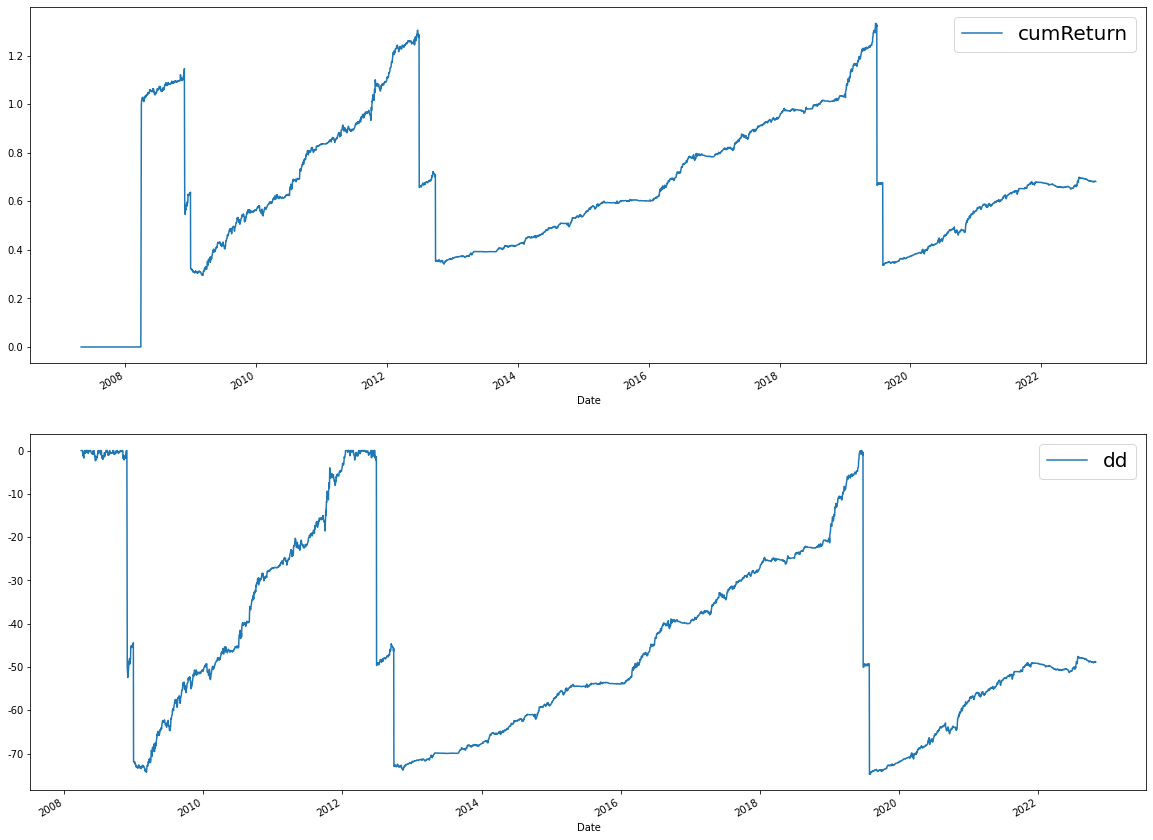

In [97]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
CumReturn.plot(label="cumReturn")
plt.legend(fontsize=20)

# dd 곡선
plt.subplot(2,1,2)
(-dd).plot(label="dd")
plt.legend(fontsize=20)

plt.show()